# Monitoreo Inteligente: Aplicaciones de clasificación con Phyphox

### **Autores**: Rubén Jordana, Asier Lorenzo y Unai Peñafiel

### 1.Introducción

El uso de redes de sensores en entornos inteligentes está en constante crecimiento. Estas redes permiten monitorear y realizar un seguimiento de las personas, lo que abre un abanico de posibilidades en aplicaciones como asistencia médica, monitoreo de la actividad física, máquinas y robots industriales, entre otros. Este informe explora el potencial de clasificación de actividades utilizando datos relativos a la aceleración obtenidos con la aplicación Phyphox. El trabajo se fundamenta en la extracción de datos con la aplicación mencionada, el análisis y comparación de los mismos en el dominio frecuencial como en el temporal y la clasificación de actividades.

### 2.Objetivos


El objetivo principal de este trabajo es investigar y demostrar la viabilidad de clasificar actividades utilizando datos del acelerómetro con Phyphox. Los objetivos específicos incluyen:

- Adquisición de datos mientras se realizan diferentes actividades (subir_monte,bajar_monte,coche,bicicleta).
- Extracción de características en el dominio del tiempo.
- Clasificación de actividades basada en las características extraídas.
- Extracción de características en el dominio de la frecuencia.
- Clasificación de actividades basada en características de frecuencia.
- Comparación de resultados obtenidos en los dominios temporal y frecuencial.
- Conclusiones y posibles líneas futuras de investigación.

### 3. Experimentación

### Librerias

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.signal import get_window
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

#### Actividad 1: Adquisición de datos

En este experimento, se utiliza la aplicación Phyphox para adquirir datos mientras se realizan las siguientes actividades:

1. Andar en bicicleta.
2. Coche en marcha.
3. Subir una montaña.
4. Bajar una montaña.

Cada actividad se ha llevado a cabo en un experimento individual y se ha obtenido aproximadamente 10 minutos de cada tipo. Los datos se etiquetan para su posterior procesamiento.

Las variables con las que cuenta cada conjunto de datos son:

- "Time (s)": El tiempo transcurrido en segundos.
- "Linear Acceleration x (m/s^2)": Aceleración lineal en el eje x en metros por segundo al cuadrado.
- "Linear Acceleration y (m/s^2)": Aceleración lineal en el eje y en metros por segundo al cuadrado.
- "Linear Acceleration z (m/s^2)": Aceleración lineal en el eje z en metros por segundo al cuadrado.
- "Absolute acceleration (m/s^2)": Aceleración absoluta en metros por segundo al cuadrado.

Estas variables proporcionan información sobre la aceleración experimentada durante cada actividad, lo que será útil para analizar el movimiento y las fuerzas involucradas en cada situación, facilitando su clasificación.

In [23]:
def carga_de_datos(nombre):
    data = pd.read_csv('./Data/'+nombre+'.csv')
    data['clase'] = nombre
    return data

def setup_graph(ax, title, x_label="Frecuencia (Hz)", y_label="Amplitud [$m/s^2$]", grid=True):
    ax.grid(grid)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [24]:
data_list= ['bajar_monte','subir_monte','bici','coche']
df_list = [carga_de_datos(data) for data in data_list]
df_bajar_monte = df_list[0]
df_subir_monte = df_list[1]
df_bici = df_list[2]
df_coche = df_list[3]

### Actividad 2: Extracción de características en el dominio del tiempo

#### Análisis visual de la Aceleración Lineal

La visualización de la aceleración lineal a lo largo del tiempo para cada actividad proporciona información sobre cómo cambia la aceleración durante la realización de las mismas. Cada gráfico muestra la aceleración en el eje x en función del tiempo para una actividad específica.

#### Significado de los gráficos:
- **Eje x (horizontal)**: Tiempo en segundos.
- **Eje y (vertical)**: Aceleración lineal en metros por segundo al cuadrado ($m/s^2$).
- Cada línea representa la variación de la aceleración durante la actividad correspondiente.

---- Aceleración Lineal ----


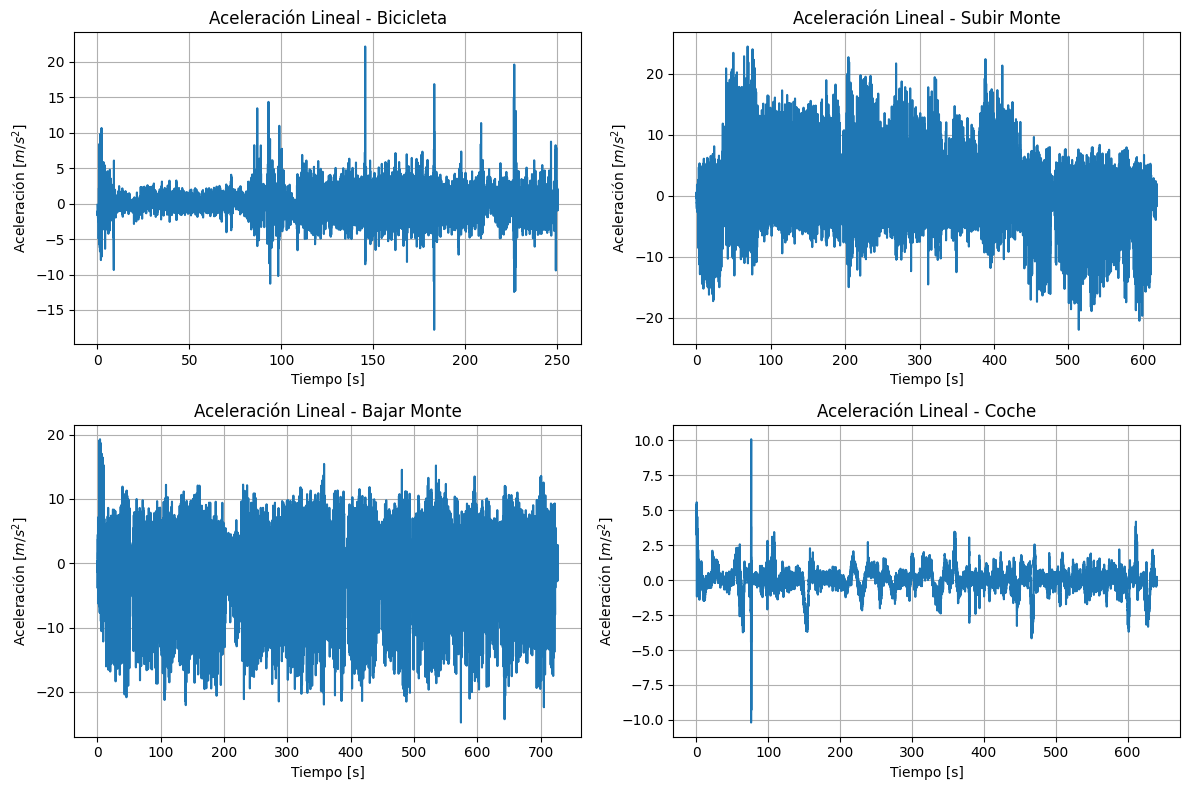

In [25]:
print('---- Aceleración Lineal ----')
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, (data, title) in enumerate([(df_bici, 'Bicicleta'), (df_subir_monte, 'Subir Monte'), (df_bajar_monte, 'Bajar Monte'), (df_coche, 'Coche')]):
    ax = axs[i // 2, i % 2]
    ax.plot(data['Time (s)'], data['Linear Acceleration x (m/s^2)'])
    setup_graph(ax, 'Aceleración Lineal - ' + title, 'Tiempo [s]', 'Aceleración [$m/s^2$]')
plt.tight_layout()
plt.show()

#### Conclusiones:
- Las fluctuaciones en la aceleración pueden indicar cambios en la velocidad o la dirección del movimiento durante la actividad.
- Comparando los gráficos de diferentes actividades, se pueden identificar patrones distintivos de aceleración asociados con cada una de ellas. Por ejemplo, la aceleración al andar en bicicleta puede mostrar un patrón más regular y periódico en comparación con subir o bajar una montaña, donde se esperan cambios bruscos en la aceleración debido a la elevación del terreno.
- Es importante tener en cuenta que los gráficos de subir y bajar montaña pueden ser más ruidosos debido a la irregularidad en la toma de datos. Esto se debe a que es más complicado que el dispositivo móvil se mantenga recto en estas condiciones, a diferencia de la bicicleta y, especialmente, el coche, donde el movimiento es más plano y uniforme.

### Análisis visual de la Velocidad

La visualización de la velocidad calculada a partir de la aceleración proporciona información adicional sobre la dinámica del movimiento durante cada actividad. La velocidad se calcula integrando la aceleración a lo largo del tiempo.

#### Significado de los gráficos:
- **Eje x (horizontal)**: Tiempo en segundos.
- **Eje y (vertical)**: Velocidad en metros por segundo ($m/s$).
- Cada línea representa la velocidad en función del tiempo para una actividad específica.

---- Velocidad ----


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22348\3610358136.py:8: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  velocity = cumtrapz(data['Linear Acceleration x (m/s^2)'], x=data['Time (s)'], initial=0)


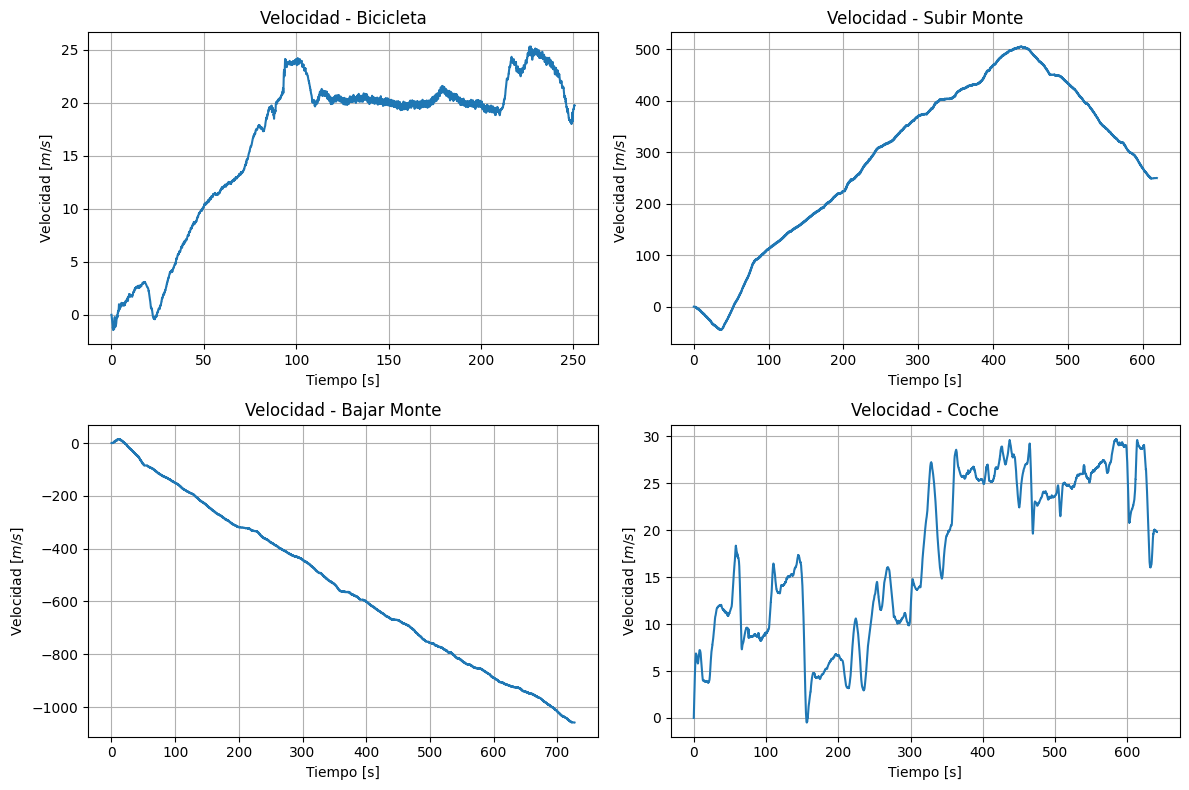

In [26]:


print('---- Velocidad ----')
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (data, title) in enumerate([(df_bici, 'Bicicleta'), (df_subir_monte, 'Subir Monte'), (df_bajar_monte, 'Bajar Monte'), (df_coche, 'Coche')]):
    ax = axs[i // 2, i % 2]
    
    # Calcula la velocidad integrando la aceleración
    velocity = cumtrapz(data['Linear Acceleration x (m/s^2)'], x=data['Time (s)'], initial=0)
    
    ax.plot(data['Time (s)'], velocity)
    setup_graph(ax, 'Velocidad - ' + title, 'Tiempo [s]', 'Velocidad [$m/s$]')

plt.tight_layout()
plt.show()

#### Conclusiones:
- La velocidad proporciona una perspectiva más clara sobre la rapidez con la que se realiza cada actividad.
- Se pueden observar cambios en la velocidad que pueden correlacionarse con cambios en la aceleración en los gráficos de aceleración lineal.
- Comparando los gráficos de velocidad de diferentes actividades, se pueden identificar diferencias significativas en los patrones de movimiento. Por ejemplo, la velocidad de subir o bajar monte puede ser más uniforme y constante en comparación con la bicicleta.

#### Extracción de características

In [27]:
# media
# std
# kurtosis
# skewness
# ...

### Actividad 3: Clasificación de actividades en base al dominio temporal

Se desarrollará un clasificador de actividades basado en las características extraídas en la actividad 2. Se emplearán métricas de clasificación y matrices de confusión para evaluar el desempeño del clasificador.

In [28]:
# clustering / clasificador

### Actividad 4: Extracción de características en el dominio de la frecuencia

En esta sección, se lleva a cabo un análisis en el dominio frecuencial de la señal registrada durante cada actividad. El dominio frecuencial proporciona información sobre las frecuencias presentes en la señal, lo que puede ser útil para identificar patrones y características específicas de las actividades realizadas.

Para cada actividad registrada, se calcula la transformada de Fourier de la señal de aceleración lineal utilizando la función np.fft.rfft(). Luego, se calcula la magnitud de la transformada de Fourier normalizada dividiendo por la longitud de la señal (len(rfft_output)). Esto proporciona la amplitud de las frecuencias presentes en la señal.

Además, se calcula la frecuencia de muestreo (fs) utilizando la diferencia media entre puntos de tiempo (T) en la señal. Esto es importante para escalar correctamente el eje x del gráfico en unidades de frecuencia.

#### Análisis visual del Dominio Frecuencial

#### Significado del Gráfico:
- El eje horizontal representa la frecuencia en hertz (Hz), que indica cuántas veces se repite un ciclo de la señal en un segundo.
- El eje vertical representa la amplitud de las frecuencias en metros por segundo al cuadrado ($m/s^2$), que indica la intensidad de las frecuencias presentes en la señal.

---- Dominio Frecuencial ----


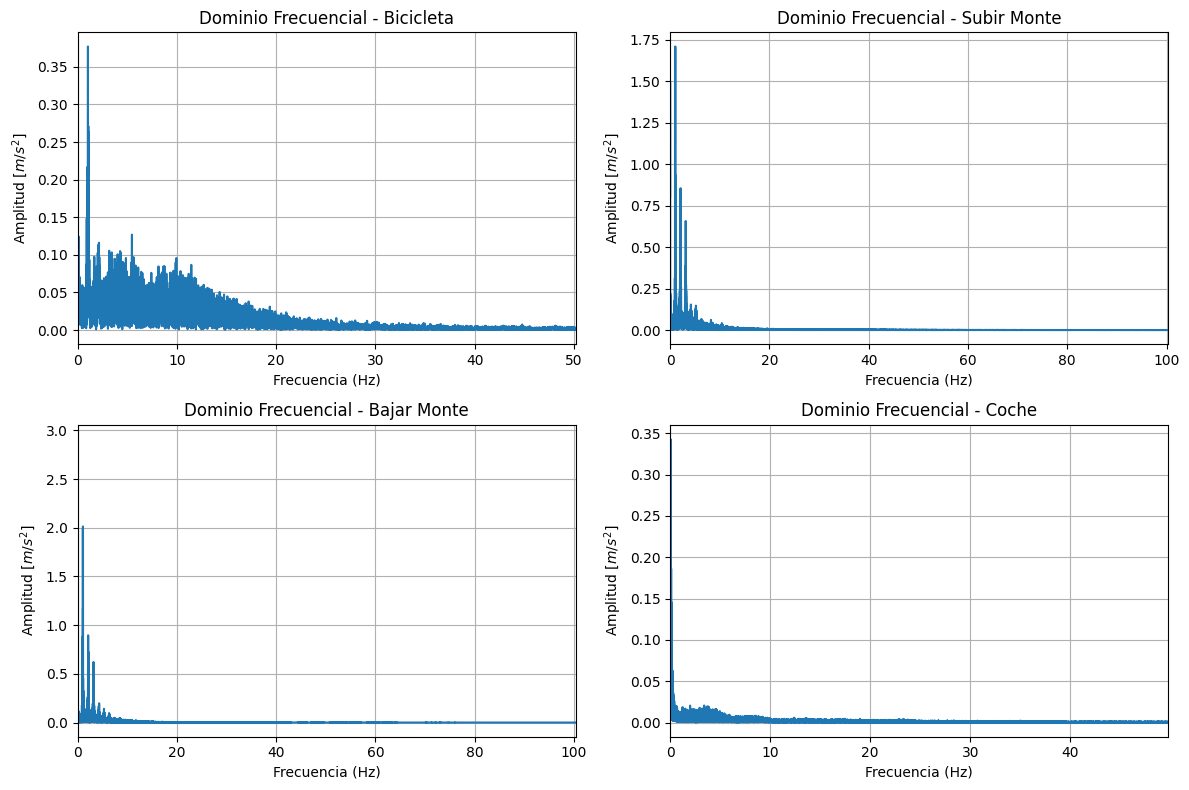

In [29]:
print('---- Dominio Frecuencial ----')
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, (data, title) in enumerate([(df_bici, 'Bicicleta'), (df_subir_monte, 'Subir Monte'), (df_bajar_monte, 'Bajar Monte'), (df_coche, 'Coche')]):
    ax = axs[i // 2, i % 2]
    rfft_output = np.fft.rfft(data['Linear Acceleration x (m/s^2)'])
    rfft_mag = np.abs(rfft_output) / len(rfft_output)
    T = data['Time (s)'].diff().mean()
    fs = 1 / T
    rfreqs = np.fft.rfftfreq(len(data), d=T)
    ax.plot(rfreqs, rfft_mag)
    setup_graph(ax, 'Dominio Frecuencial - ' + title)
    ax.set_ylabel('Amplitud [$m/s^2$]')
    ax.set_xlim(0, fs/2)  # Limitar el eje x hasta la mitad de la frecuencia de muestreo
plt.tight_layout()
plt.show()

#### Conclusiones:

El análisis en el **dominio frecuencial** revela las características de vibración de diferentes actividades, como andar en bicicleta y conducir un coche, identificando **frecuencias dominantes** y **amplitudes de vibración**. La bicicleta muestra una frecuencia dominante de **20 Hz** en llano, aumentando a **40 Hz** al subir un monte y a **60 Hz** al bajarlo, con amplitudes crecientes. En comparación, el coche presenta una frecuencia dominante de **80 Hz** con una amplitud intermedia. Estas diferencias sugieren influencias de la velocidad, la rugosidad de la carretera y el diseño del vehículo en las vibraciones observadas.


### Análisis visual de la Ventana de Hanning

Se usa la ventana de Hanning para suavizar la señal de aceleración lineal registrada durante cada actividad. Se busca reducir el efecto de los artefactos de borde y mejorar la resolución espectral de la señal antes de realizar el análisis en el dominio frecuencial.

#### Significado del Gráfico:
- El eje horizontal representa la frecuencia en hertz (Hz), que indica cuántas veces se repite un ciclo de la señal en un segundo.
- El eje vertical representa la amplitud de las frecuencias en metros por segundo al cuadrado ($m/s^2$), que indica la intensidad de las frecuencias presentes en la señal.

---- Ventana de Hanning ----


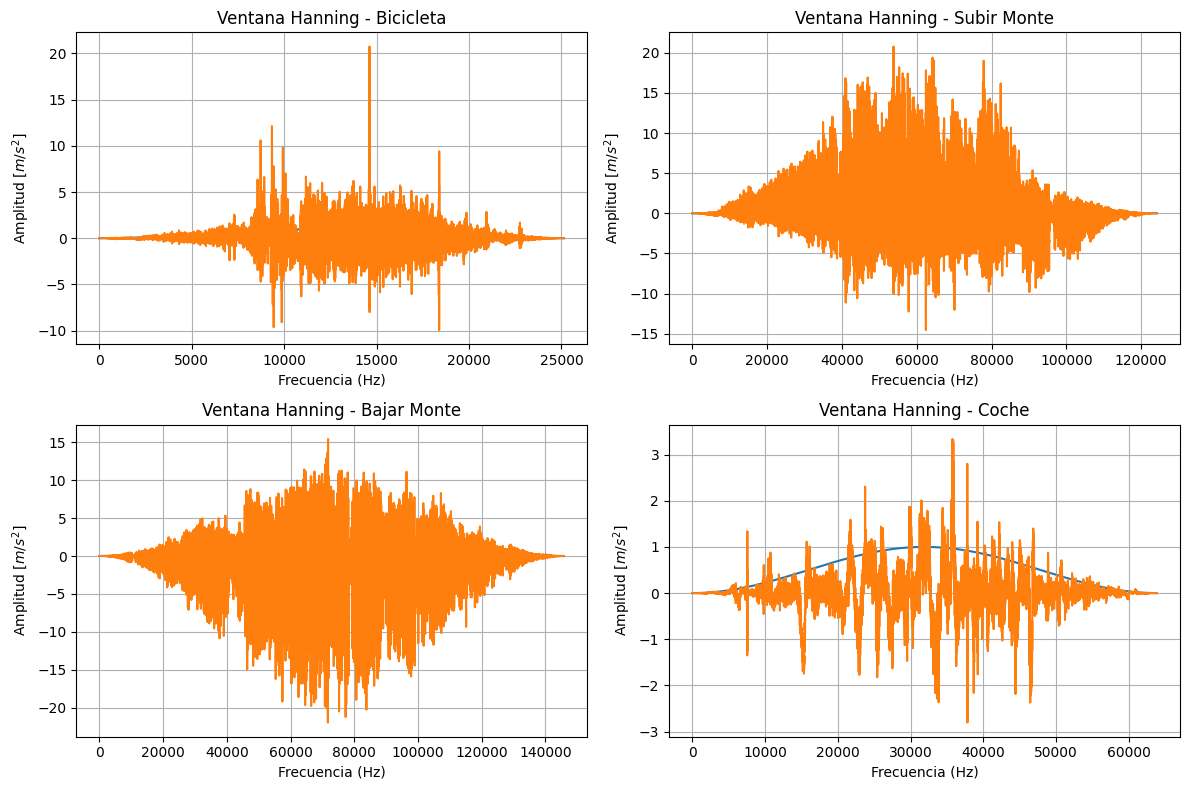

In [30]:
print('---- Ventana de Hanning ----')
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, (data, title) in enumerate([(df_bici, 'Bicicleta'), (df_subir_monte, 'Subir Monte'), (df_bajar_monte, 'Bajar Monte'), (df_coche, 'Coche')]):
    ax = axs[i // 2, i % 2]
    window = get_window("hann", len(data), fftbins=True)
    ax.plot(window)
    ax.set_ylabel('Samples')
    ax.set_xlabel('Frecuencia [Hz]')
    setup_graph(ax, 'Ventana Hanning - ' + title)
    ax.plot(data['Linear Acceleration x (m/s^2)'] * window)
    
plt.tight_layout()
plt.show()


#### Creación del Dataset de Características del Dominio Frecuencial

Para crear un dataset que contenga características del dominio frecuencial, se ha utilizado la función `Myfft` para calcular la transformada de Fourier de ventanas deslizantes de la señal de aceleración en los tres ejes (x, y, z) para cada muestra de datos. Luego, se han extraido características relevantes de las transformadas de Fourier, como la frecuencia dominante y la suma de las magnitudes de las frecuencias presentes.

##### Función `Myfft`:
- `Myfft` es una función que toma la frecuencia de muestreo (Fs) y la señal de entrada (X) y calcula la transformada de Fourier utilizando la ventana de Hanning para suavizar la señal.
- Devuelve la magnitud de la transformada de Fourier normalizada y las frecuencias correspondientes.

##### Función `freq_features`:
- `freq_features` toma un dataframe con los datos originales, el nombre de la clase a la que pertenecen los datos (nombre), y los tamaños de ventana y paso para calcular las características del dominio frecuencial.
- Itera sobre las muestras de datos con la ventana deslizante, calcula la transformada de Fourier para cada eje de la señal de aceleración en la ventana, y extrae características como la frecuencia dominante y la suma de las magnitudes de las frecuencias presentes.
- Retorna un dataframe con las características extraídas.

#### Variables del DataFrame Resultante:
- `DF X`: Frecuencia dominante en el eje X.
- `PSD X`: Suma de las magnitudes de las frecuencias en el eje X.
- `DF Y`: Frecuencia dominante en el eje Y.
- `PSD Y`: Suma de las magnitudes de las frecuencias en el eje Y.
- `DF Z`: Frecuencia dominante en el eje Z.
- `PSD Z`: Suma de las magnitudes de las frecuencias en el eje Z.
- `clase`: Clase a la que pertenecen los datos, indicando la actividad realizada (subir_monte, bajar_monte, bici, coche).


In [31]:
def Myfft(Fs, X):
    from scipy.signal import get_window
    window = get_window("hann", len(X), fftbins=True)
    X=X*window
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return fft_mag, rfreqs

In [32]:
def freq_features(raw_df, nombre, window_size=1000, step_size=500):
    data = []
    for i in range(0, len(raw_df) - window_size + 1, step_size):
        window_data_X = raw_df.iloc[i:i+window_size, 1] 
        window_data_Y = raw_df.iloc[i:i+window_size, 2] 
        window_data_Z = raw_df.iloc[i:i+window_size, 3]  

        fft_mag_X, fft_freq = Myfft(fs, window_data_X)
        fft_mag_Y, _ = Myfft(fs, window_data_Y)
        fft_mag_Z, _ = Myfft(fs, window_data_Z)
        data.append([fft_freq[np.argmax(fft_mag_X)], np.sum(fft_mag_X),
                     fft_freq[np.argmax(fft_mag_Y)], np.sum(fft_mag_Y),
                     fft_freq[np.argmax(fft_mag_Z)], np.sum(fft_mag_Z), nombre])

    freq_features = pd.DataFrame(data, columns=['DF X', 'PSD X', 'DF Y', 'PSD Y', 'DF Z', 'PSD Z', 'clase'])
    return freq_features

In [33]:
subir_monte = freq_features(df_subir_monte, 'subir_monte')
bajar_monte = freq_features(df_bajar_monte, 'bajar_monte')
bici = freq_features(df_bici, 'bici')
coche = freq_features(df_coche, 'coche')
df_frecuencial=pd.concat([subir_monte, bajar_monte,bici,coche])
print(df_frecuencial.head())
print(df_frecuencial['clase'].value_counts())

       DF X      PSD X      DF Y      PSD Y      DF Z      PSD Z        clase
0  0.497741  19.015551  0.597289  15.583148  0.497741  23.675710  subir_monte
1  0.497741  19.511018  0.497741  15.326879  0.000000  13.028594  subir_monte
2  0.497741  20.601642  0.497741  15.315404  0.000000  13.420502  subir_monte
3  0.497741  20.959415  0.497741  16.260063  0.000000  12.203606  subir_monte
4  0.497741  19.254408  0.497741  14.718024  0.000000  10.437852  subir_monte
clase
bajar_monte    290
subir_monte    247
coche          126
bici            49
Name: count, dtype: int64


### Actividad 5: Clasificación de actividades en base al dominio frecuencial.

#### Objetivo del Modelo:
- El modelo de clasificación tiene como objetivo clasificar las actividades registradas (subir monte, bajar monte, andar en bicicleta y conducir un coche) utilizando características del dominio frecuencial extraídas previamente.

#### Modelo Utilizado:
- `AdaBoost` (Adaptive Boosting) es un algoritmo de aprendizaje automático supervisado que se utiliza para mejorar la precisión de los modelos de clasificación débiles. En este caso, el estimador base utilizado es el Bosques Aleatorios (Random Forest).
- Los bosques aleatorios son un conjunto de árboles de decisión, donde cada árbol se entrena con una muestra aleatoria de las características y las observaciones. La predicción final se obtiene promediando las predicciones de todos los árboles.

#### Funcionamiento del AdaBoost:
1. Inicialmente, cada observación en el conjunto de datos tiene un peso igual.
2. Se entrena un estimador base (en este caso, un Bosque Aleatorio) con los datos de entrenamiento.
3. Se calcula el error del clasificador base.
4. Se ajustan los pesos de las observaciones, dándole más peso a las observaciones que fueron mal clasificadas y menos peso a las bien clasificadas.
5. Se repite el proceso de entrenamiento del clasificador base y ajuste de pesos varias veces (según el número de estimadores).
6. Finalmente, se combina la predicción de cada clasificador base ponderando su contribución en función de su precisión.

In [34]:
le = LabelEncoder()
df_frecuencial['clase'] = le.fit_transform(df_frecuencial['clase'])

X = df_frecuencial.drop('clase', axis=1)
y = df_frecuencial['clase']
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

dt = RandomForestClassifier(n_estimators=300, random_state=44)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=500, random_state=44)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.2%}')

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

#### Conclusiones del modelo

La matriz de confusión muestra que el modelo tiene una alta precisión general, con un 88% de aciertos.
Sin embargo, el modelo confunde las clases de "subir monte" y "bajar monte", con un 20% de errores en ambas clases.
Esto indica que el modelo tiene dificultades para distinguir entre estas dos clases, posiblemente debido a la similitud de las características que las definen, como la velocidad y la pendiente. El modelo puede no tener suficientes datos para aprender a distinguir correctamente entre estas dos clases.

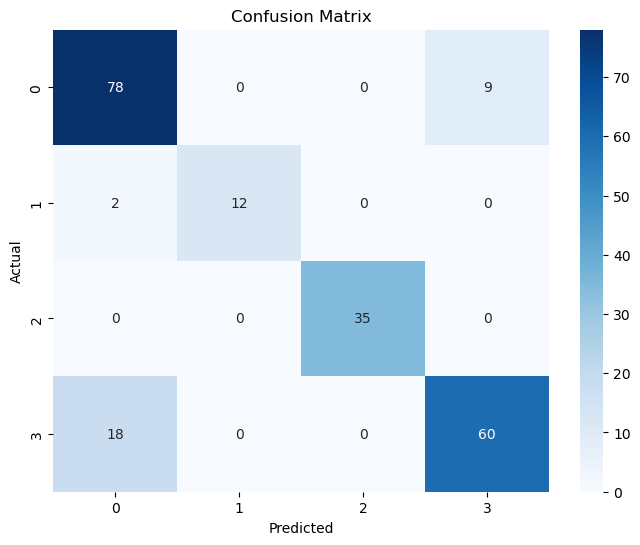

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Actividad 6: Comparación entre los clasificadores en el dominio temporal y frecuencial

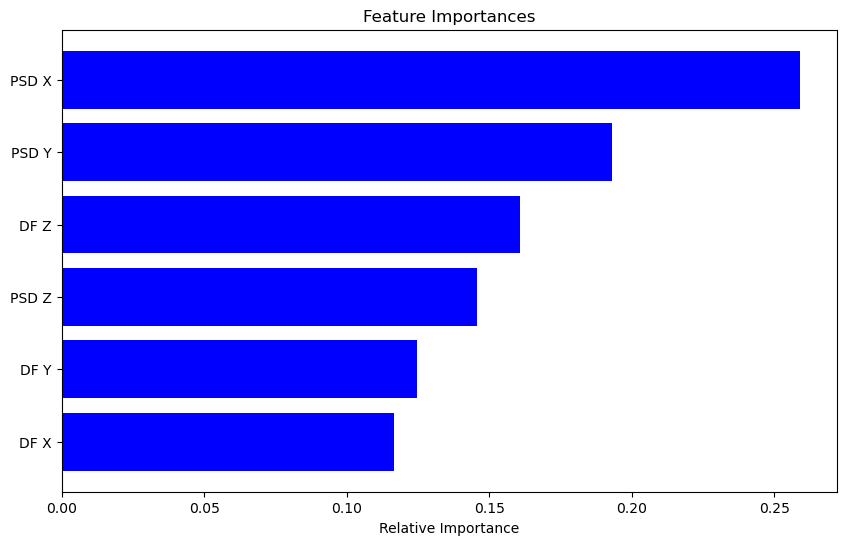

In [ ]:
importances = ada.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Actividad 7: Conclusiones y lineas futuras